# Wine Reviews Natural Language Processing

**Prepared by Elizabeth Webster**

*November 2022*

## Overview

Natural Language Processing to discover which attributes are indicative of a highly scoring wine.

## Business Problem

This project is being prepared for a small winery in Walla Walla.  They are just starting out and currently only producing a few wines. Their wine maker wants to gain insight on which wine qualities generate highly rated wines.

In this section of the project, I will create a model to predict wine scores that can be used to assess how well the current wines would be rated. 

I will also pick out keywords and flavor profiles from wine descriptions that relate to high and low scoring wines in order for the wine maker to understand what direction to move in. 

Finally, I will look into what wine varieties are currently receiving high scores.

## Dataset

The data that I am using comes from Wine Enthusiast and includes information on 130,000 different wines.  This information includes the description, variety, winery, country, taster name, etc.  

The target value is the 'points' column.  This column contains a score from 80 to 100 for each wine.  All the wines in this range are perfectly drinkable, but I have broken down this category into four ranges:
* 80-84 points: 0 - Acceptable
* 85-89 points: 1 - Good
* 90-94 points: 2 - Very Good
* 95-100 points: 3 - Outstanding

I will be looking at what sets 'Outstanding' wines apart from the 'Acceptable' ones.

# Building a Model

First, I will build a Naive Bayes model that the wine maker can utilize to predict how well their current wines will perform.

## Data Understanding

Before diving into NLP, I will explore and clean my dataset.

In [1]:
# Import the necessary libraries
import pandas as pd
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import nltk
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
import warnings
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
warnings.filterwarnings('ignore')

In [2]:
# Create the DataFrame
df = pd.read_csv('Data/winemag-data-130k-v2.csv.zip', 
                 encoding='latin-1', index_col=0)

In [3]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",VulkÃ Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin OâKeefe,@kerinokeefe,Nicosia 2013 VulkÃ Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwineÂ,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwineÂ,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


Before going any further, I am dropping columns that are missing high numbers of values (designation, region_1, region_2) and dropping taster info (taster_name, taster_twitter_handle) and title as these columns should not impact point value.

In [5]:
# Drop unneccessary columns
wine_df = df.drop(['designation', 'region_1', 'region_2', 
                   'taster_name', 'taster_twitter_handle',
                   'title'], axis=1)
wine_df.head()

,country,description,points,price,province,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,Sweet Cheeks


In [6]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   province     129908 non-null  object 
 5   variety      129970 non-null  object 
 6   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 7.9+ MB


We still have some columns with missing values, which we will tackle later on.

### Point Distribution

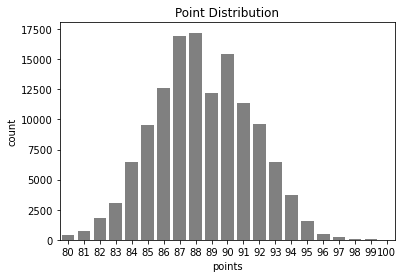

In [9]:
# Create a plot to illustrate the distribution of our target value
sns_plot = sns.countplot(x='points', data=wine_df, color='grey').set(title='Point Distribution')
#plt.savefig('Point_Distribution.jpeg')

Our target is the number of points that a wine has scored out of 100.  Unsurprisingly, it follows a normal distribution. Since we are creating a classification model we will break our target up into 4 categories:

* 80-84 points: 0 - Acceptable
* 85-89 points: 1 - Good
* 90-94 points: 2 - Very Good
* 95-100 points: 3 - Outstanding

In [78]:
# Rename target values
wine_df['sentiment'] = 0
for i in range(len(wine_df)):
    if wine_df['points'][i] <= 84:
        wine_df['sentiment'][i] = 0
    else:
        pass
    
for i in range(len(wine_df)):    
    if (wine_df['points'][i] > 84 and wine_df['points'][i] <= 89):
        wine_df['sentiment'][i] = 1
    else:
        pass
    
for i in range(len(wine_df)):
    if (wine_df['points'][i] > 89 and wine_df['points'][i] <= 94):
        wine_df['sentiment'][i] = 2
    else:
        pass
    
for i in range(len(wine_df)):
    if wine_df['points'][i] > 94:
        wine_df['sentiment'][i] = 3
    else:
        pass

In [79]:
wine_df['sentiment'].value_counts()

1    68496
2    46629
0    12430
3     2416
Name: sentiment, dtype: int64

I will drop the points column since we no longer need it.

In [80]:
wine_df.drop('points', axis=1, inplace=True)
wine_df

,country,description,price,province,variety,winery,sentiment
0,Italy,"Aromas include tropical fruit, broom, brimston...",NaN,Sicily & Sardinia,White Blend,Nicosia,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Portuguese Red,Quinta dos Avidagos,1
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Pinot Gris,Rainstorm,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,Riesling,St. Julian,1
4,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Pinot Noir,Sweet Cheeks,1
...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,28.0,Mosel,Riesling,Dr. H. Thanisch (Erben MÃ¼ller-Burggraef),2
129967,US,Citation is given as much as a decade of bottl...,75.0,Oregon,Pinot Noir,Citation,2
129968,France,Well-drained gravel soil gives this wine its c...,30.0,Alsace,GewÃ¼rztraminer,Domaine Gresser,2
129969,France,"A dry style of Pinot Gris, this is crisp with ...",32.0,Alsace,Pinot Gris,Domaine Marcel Deiss,2


## Data Cleaning

### Dealing with Missing Values

I will drop NaNs for:
* country (63 - .04%)
* province (63 - .04%)
* variety (1)

I will use mean for filling NaN prices (8996 - 6% of dataset) after the train test split.

In [81]:
# Drop NaNs in country, province, and variety
wine_df.dropna(subset=['country', 'province', 'variety'], inplace=True)

In [82]:
# Reset the index
wine_df.reset_index(drop=True, inplace=True)

In [83]:
# Check for missing values
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129907 entries, 0 to 129906
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129907 non-null  object 
 1   description  129907 non-null  object 
 2   price        120915 non-null  float64
 3   province     129907 non-null  object 
 4   variety      129907 non-null  object 
 5   winery       129907 non-null  object 
 6   sentiment    129907 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 6.9+ MB


The only column missing values is price and we will address that after our split to avoid data leakage.

### Train Test Split

In [84]:
# Create data and target dataframes
X = wine_df.drop(['sentiment'], axis=1)
y = wine_df['sentiment']

In [85]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    random_state=42)

In [86]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90934 entries, 32539 to 121958
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      90934 non-null  object 
 1   description  90934 non-null  object 
 2   price        84667 non-null  float64
 3   province     90934 non-null  object 
 4   variety      90934 non-null  object 
 5   winery       90934 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.9+ MB


In [87]:
print("Now I will fill the missing price data with the mean:", 
      round(X_train.price.mean(),2))

Now I will fill the missing price data with the mean: 35.32


In [88]:
X_train['price'].fillna((X_train['price'].mean()), inplace=True)

In [89]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90934 entries, 32539 to 121958
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      90934 non-null  object 
 1   description  90934 non-null  object 
 2   price        90934 non-null  float64
 3   province     90934 non-null  object 
 4   variety      90934 non-null  object 
 5   winery       90934 non-null  object 
dtypes: float64(1), object(5)
memory usage: 4.9+ MB


### One Hot Encode Categoricals

In order to use all of the data, I need to One Hot Encode the following categorical columns:
* Country
* Province
* Variety
* Winery

In [90]:
# Create a categorical DataFrame
X_train_cat = X_train.drop(['description', 'price'], axis=1)

In [91]:
# Instantiate a One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore')

In [92]:
# Fit and transform the categorical df
X_train_cat_ohe = ohe.fit_transform(X_train_cat)
X_train_cat_ohe

<90934x16278 sparse matrix of type '<class 'numpy.float64'>'
	with 363736 stored elements in Compressed Sparse Row format>

In [93]:
# Transform sparse matrix to DataFrame
X_train_cat_final = pd.DataFrame.sparse.from_spmatrix(X_train_cat_ohe, 
                                                      columns=ohe.get_feature_names(),
                                                      index=X_train_cat.index)

In [94]:
X_train_cat_final.head()

,x0_Argentina,x0_Armenia,x0_Australia,x0_Austria,x0_Bosnia and Herzegovina,x0_Brazil,x0_Bulgaria,x0_Canada,x0_Chile,x0_China,...,x3_Ãbano,x3_Ãcluse,x3_ÃlevÃ©e Winegrowers,x3_Ãric & JÃ¶el Durand,x3_Ãl Macchione,x3_Ãrale,x3_Ãko,x3_Ãkonomierat Rebholz,x3_Ã Maurice,x3_Å toka
32539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82091,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# Create dataframe with continuous values ('price') and concat with categoricals
X_train_cont = X_train['price']
X_train_without_text = pd.concat([X_train_cat_final, X_train_cont], axis=1)

### Build a Baseline Model

#### Text Only Baseline Model

Before joining it with our categorical values, lets see how well a model based solely on text performs.

In [96]:
# Vectorize X_train text
tfidf = TfidfVectorizer(max_features=20)
X_train_text_vectorized = tfidf.fit_transform(X_train['description'])
pd.DataFrame.sparse.from_spmatrix(X_train_text_vectorized, 
                                  columns=tfidf.get_feature_names(),
                                  index=X_train.index)

,acidity,and,aromas,but,finish,flavors,from,fruit,in,is,it,of,on,palate,that,the,this,to,wine,with
32539,0.261794,0.000000,0.246307,0.000000,0.000000,0.000000,0.00000,0.231912,0.222482,0.180810,0.189651,0.141615,0.000000,0.250530,0.257448,0.679290,0.000000,0.228462,0.190068,0.000000
91312,0.000000,0.623943,0.269130,0.000000,0.000000,0.000000,0.00000,0.253401,0.243098,0.000000,0.207224,0.309474,0.000000,0.000000,0.000000,0.296893,0.156136,0.000000,0.207680,0.347254
50735,0.000000,0.498093,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.262859,0.000000,0.617632,0.364161,0.000000,0.000000,0.197508,0.000000,0.000000,0.276318,0.231010
82091,0.331833,0.289521,0.312203,0.000000,0.329160,0.252615,0.00000,0.000000,0.000000,0.229184,0.000000,0.179502,0.317508,0.317556,0.000000,0.344410,0.181124,0.000000,0.240918,0.201415
26122,0.000000,0.265876,0.000000,0.219857,0.000000,0.154656,0.00000,0.179966,0.172649,0.561244,0.147171,0.329684,0.000000,0.000000,0.199783,0.421709,0.221776,0.000000,0.147495,0.246621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,0.000000,0.508705,0.365706,0.000000,0.000000,0.295906,0.00000,0.000000,0.000000,0.000000,0.000000,0.420527,0.000000,0.000000,0.000000,0.403432,0.212164,0.000000,0.282205,0.235932
103694,0.000000,0.284329,0.000000,0.000000,0.323258,0.248085,0.00000,0.000000,0.553895,0.225074,0.236079,0.528850,0.000000,0.000000,0.000000,0.169117,0.177877,0.000000,0.000000,0.000000
860,0.000000,0.401472,0.000000,0.000000,0.000000,0.233530,0.33151,0.543498,0.000000,0.211869,0.000000,0.165941,0.293521,0.000000,0.301672,0.318391,0.167441,0.000000,0.000000,0.000000
15795,0.000000,0.298745,0.000000,0.247037,0.000000,0.000000,0.00000,0.202215,0.000000,0.157657,0.330731,0.493923,0.000000,0.000000,0.000000,0.236922,0.124597,0.398414,0.165730,0.415665


In [97]:
#Multinomial Bayes Baseline Model
baseline_model_text_only = MultinomialNB()

# Evaluate the model on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model_text_only, 
                              X_train_text_vectorized, 
                              y_train)
baseline_cv.mean()

0.5284712020496571

This model is giving us only a 52.8% accuracy. Lets see how this improves by adding in price and our categorical columns.

#### Baseline with all variables

In [98]:
# Create dataframe with all information
X_train_vectorized_df = pd.DataFrame(X_train_text_vectorized.toarray(), 
                                     columns=tfidf.get_feature_names(), 
                                     index=X_train.index)
preprocessed_X_train_1 = pd.concat([X_train_vectorized_df, 
                                  X_train_without_text], 
                                 axis=1)
preprocessed_X_train_1

,acidity,and,aromas,but,finish,flavors,from,fruit,in,is,...,x3_Ãcluse,x3_ÃlevÃ©e Winegrowers,x3_Ãric & JÃ¶el Durand,x3_Ãl Macchione,x3_Ãrale,x3_Ãko,x3_Ãkonomierat Rebholz,x3_Ã Maurice,x3_Å toka,price
32539,0.261794,0.000000,0.246307,0.000000,0.000000,0.000000,0.00000,0.231912,0.222482,0.180810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.316889
91312,0.000000,0.623943,0.269130,0.000000,0.000000,0.000000,0.00000,0.253401,0.243098,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.000000
50735,0.000000,0.498093,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.262859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.316889
82091,0.331833,0.289521,0.312203,0.000000,0.329160,0.252615,0.00000,0.000000,0.000000,0.229184,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.000000
26122,0.000000,0.265876,0.000000,0.219857,0.000000,0.154656,0.00000,0.179966,0.172649,0.561244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,0.000000,0.508705,0.365706,0.000000,0.000000,0.295906,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.000000
103694,0.000000,0.284329,0.000000,0.000000,0.323258,0.248085,0.00000,0.000000,0.553895,0.225074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000
860,0.000000,0.401472,0.000000,0.000000,0.000000,0.233530,0.33151,0.543498,0.000000,0.211869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.000000
15795,0.000000,0.298745,0.000000,0.247037,0.000000,0.000000,0.00000,0.202215,0.000000,0.157657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000


In [99]:
#Multinomial Bayes Baseline Model
baseline_model = MultinomialNB()

# Evaluate the model on X_train_vectorized and y_train
baseline_cv_2 = cross_val_score(baseline_model, preprocessed_X_train_1, y_train)
print('Baseline Text:', baseline_cv.mean())
print('Baseline:', baseline_cv_2.mean())

Baseline Text: 0.5284712020496571
Baseline: 0.6437855405314841


This model is performing slightly better.  I will fit this model in order to view a classification report.

#### Final Baseline Model

In [100]:
# Fit final baseline model
final_baseline = MultinomialNB()

final_baseline.fit(preprocessed_X_train_1, y_train)
print('Final baseline training score:', final_baseline.score(preprocessed_X_train_1, 
                                                          y_train))

Final baseline training score: 0.6792288912837883


In [101]:
# One hot encode X_test
X_test_cat = X_test.drop(['description', 'price'], axis=1)
X_test_cat_ohe = ohe.transform(X_test_cat)
X_test_cat_final = pd.DataFrame.sparse.from_spmatrix(X_test_cat_ohe, 
                                                     columns=ohe.get_feature_names(),
                                                     index=X_test_cat.index)

In [102]:
X_test['price'].fillna((X_test['price'].mean()), inplace=True)
X_test_cont = X_test['price']
X_test_without_text = pd.concat([X_test_cat_final, X_test_cont], axis=1)

In [103]:
# Vectorize X_test
X_test_vectorized = tfidf.transform(X_test["description"])
X_test_text_df = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, 
                                              columns=tfidf.get_feature_names(),
                                              index=X_test.index)
X_test_preprocessed_1 = pd.concat([X_test_text_df, X_test_without_text], axis=1)

In [104]:
# Evaluate test score
print('Final model test score:', final_baseline.score(X_test_preprocessed_1, y_test))

Final model test score: 0.6400071844610371


In [105]:
# Print a classification report
y_pred = final_baseline.predict(X_test_preprocessed_1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.26      0.32      3830
           1       0.68      0.70      0.69     20421
           2       0.62      0.69      0.65     13954
           3       0.71      0.07      0.13       768

    accuracy                           0.64     38973
   macro avg       0.61      0.43      0.45     38973
weighted avg       0.63      0.64      0.63     38973



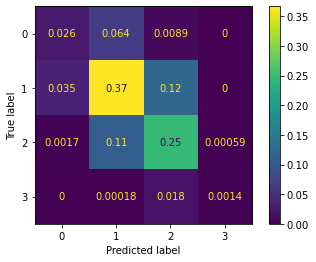

In [106]:
# Create confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(final_baseline, 
                      X_test_preprocessed_1, 
                      y_test,
                      normalize='all');
#plt.savefig('ConfusionMatrix_1.jpg')

This model is not terrible, but I will try to increase it's accuracy with Natural Language Processing.

## Natural Language Processing

Using NLP should increase our model's accuracy by removing unnecessary words and figures (such as punctuation).

In [107]:
# Create a separate dataframe to work in
nlp_df = X_train.loc[:, ['description', 'price']]
nlp_df.head()

,description,price
32539,"Gold in color, the wine has honeyed botrytis a...",35.316889
91312,Strong pencil shaving aromas open this 80% who...,28.000000
50735,A blend of 50% Nero di Troia and 50% Cabernet ...,35.316889
82091,Fragrant lemon-lime and exotic bath soap aroma...,20.000000
26122,This is winemaker Rich Cushman's estate vineya...,14.000000


Note: I created this DataFrame with price included so that my information was still labeled by column.

### Lowercase Text

In [108]:
# Lowercase text
nlp_df['description'] = nlp_df['description'].str.lower()
nlp_df.head()

,description,price
32539,"gold in color, the wine has honeyed botrytis a...",35.316889
91312,strong pencil shaving aromas open this 80% who...,28.000000
50735,a blend of 50% nero di troia and 50% cabernet ...,35.316889
82091,fragrant lemon-lime and exotic bath soap aroma...,20.000000
26122,this is winemaker rich cushman's estate vineya...,14.000000


### Tokenize and Remove Punctuation

In [109]:
# Create a basic token pattern to remove punctuation when tokenizing
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [110]:
# Create a new columns for tokenized text
nlp_df['text_tokenized'] = nlp_df['description'].apply(tokenizer.tokenize)
nlp_df.head()

,description,price,text_tokenized
32539,"gold in color, the wine has honeyed botrytis a...",35.316889,"[gold, in, color, the, wine, has, honeyed, bot..."
91312,strong pencil shaving aromas open this 80% who...,28.000000,"[strong, pencil, shaving, aromas, open, this, ..."
50735,a blend of 50% nero di troia and 50% cabernet ...,35.316889,"[blend, of, 50, nero, di, troia, and, 50, cabe..."
82091,fragrant lemon-lime and exotic bath soap aroma...,20.000000,"[fragrant, lemon, lime, and, exotic, bath, soa..."
26122,this is winemaker rich cushman's estate vineya...,14.000000,"[this, is, winemaker, rich, cushman, estate, v..."


### Remove Stopwords

Before removing stopwords, I would like to view the top 20 most common words.

In [111]:
# Create a frequency distribution for text tokenized
train_freq_dist = FreqDist(nlp_df['text_tokenized'].explode())
train_freq_dist

FreqDist({'and': 243455, 'the': 154705, 'of': 121046, 'with': 84316, 'this': 79832, 'is': 67720, 'it': 60144, 'wine': 56157, 'flavors': 43824, 'in': 43554, ...})

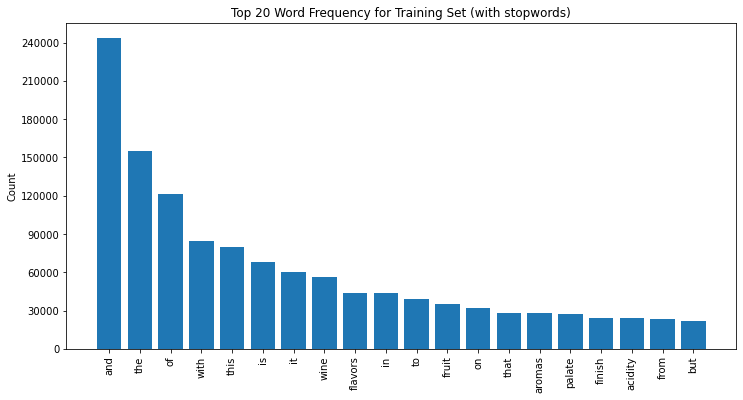

In [112]:
# Create a function for plotting the top 20 words
def visualize_top_20(freq_dist, title):

    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(tokens, counts)

    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_20(train_freq_dist, 
                 "Top 20 Word Frequency for Training Set (with stopwords)")

In [113]:
# Create a list of english stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [114]:
# Add stopwords specific to this dataset
wine = ['wine', 'flavors', 'fruit', 'palate', 'finish']
stopwords.extend(wine)

In [115]:
# Create a function for removing stopwords
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords]
    return stopwords_removed

In [116]:
# Create a new column for text without stopwords
nlp_df['text_without_stopwords'] = nlp_df['text_tokenized'].apply(remove_stopwords)
nlp_df.head()

,description,price,text_tokenized,text_without_stopwords
32539,"gold in color, the wine has honeyed botrytis a...",35.316889,"[gold, in, color, the, wine, has, honeyed, bot...","[gold, color, honeyed, botrytis, aromas, trans..."
91312,strong pencil shaving aromas open this 80% who...,28.000000,"[strong, pencil, shaving, aromas, open, this, ...","[strong, pencil, shaving, aromas, open, 80, wh..."
50735,a blend of 50% nero di troia and 50% cabernet ...,35.316889,"[blend, of, 50, nero, di, troia, and, 50, cabe...","[blend, 50, nero, di, troia, 50, cabernet, sau..."
82091,fragrant lemon-lime and exotic bath soap aroma...,20.000000,"[fragrant, lemon, lime, and, exotic, bath, soa...","[fragrant, lemon, lime, exotic, bath, soap, ar..."
26122,this is winemaker rich cushman's estate vineya...,14.000000,"[this, is, winemaker, rich, cushman, estate, v...","[winemaker, rich, cushman, estate, vineyard, 2..."


Check the new top 20 words once stopwords have been removed.

In [117]:
# New frequency distribution
new_train_freq_dist = FreqDist(nlp_df['text_without_stopwords'].explode())

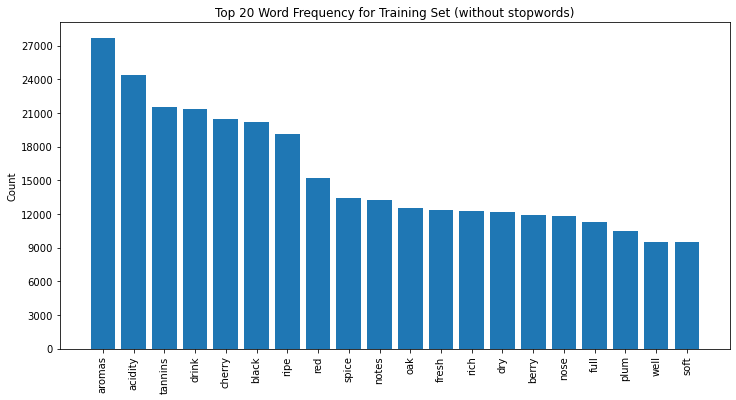

In [118]:
visualize_top_20(new_train_freq_dist, 
                 "Top 20 Word Frequency for Training Set (without stopwords)")

### Lemmatize

Finally, we will lemmatize our text to remove different tenses of the same word.

In [119]:
# Create a function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lemmatize_text(token_list):
    lemmatized_text = [lemmatizer.lemmatize(word) for word in token_list]
    return lemmatized_text

In [120]:
# Create a new column for lemmatized text
nlp_df['lemmatized_text'] = nlp_df['text_without_stopwords'].apply(lemmatize_text)
nlp_df.head()

,description,price,text_tokenized,text_without_stopwords,lemmatized_text
32539,"gold in color, the wine has honeyed botrytis a...",35.316889,"[gold, in, color, the, wine, has, honeyed, bot...","[gold, color, honeyed, botrytis, aromas, trans...","[gold, color, honeyed, botrytis, aroma, transl..."
91312,strong pencil shaving aromas open this 80% who...,28.000000,"[strong, pencil, shaving, aromas, open, this, ...","[strong, pencil, shaving, aromas, open, 80, wh...","[strong, pencil, shaving, aroma, open, 80, who..."
50735,a blend of 50% nero di troia and 50% cabernet ...,35.316889,"[blend, of, 50, nero, di, troia, and, 50, cabe...","[blend, 50, nero, di, troia, 50, cabernet, sau...","[blend, 50, nero, di, troia, 50, cabernet, sau..."
82091,fragrant lemon-lime and exotic bath soap aroma...,20.000000,"[fragrant, lemon, lime, and, exotic, bath, soa...","[fragrant, lemon, lime, exotic, bath, soap, ar...","[fragrant, lemon, lime, exotic, bath, soap, ar..."
26122,this is winemaker rich cushman's estate vineya...,14.000000,"[this, is, winemaker, rich, cushman, estate, v...","[winemaker, rich, cushman, estate, vineyard, 2...","[winemaker, rich, cushman, estate, vineyard, 2..."


In [121]:
# Create a new column for the final text string
nlp_df['final_text'] = nlp_df['lemmatized_text'].apply(lambda x: ' '.join(x))
nlp_df.head()

,description,price,text_tokenized,text_without_stopwords,lemmatized_text,final_text
32539,"gold in color, the wine has honeyed botrytis a...",35.316889,"[gold, in, color, the, wine, has, honeyed, bot...","[gold, color, honeyed, botrytis, aromas, trans...","[gold, color, honeyed, botrytis, aroma, transl...",gold color honeyed botrytis aroma translate su...
91312,strong pencil shaving aromas open this 80% who...,28.000000,"[strong, pencil, shaving, aromas, open, this, ...","[strong, pencil, shaving, aromas, open, 80, wh...","[strong, pencil, shaving, aroma, open, 80, who...",strong pencil shaving aroma open 80 whole clus...
50735,a blend of 50% nero di troia and 50% cabernet ...,35.316889,"[blend, of, 50, nero, di, troia, and, 50, cabe...","[blend, 50, nero, di, troia, 50, cabernet, sau...","[blend, 50, nero, di, troia, 50, cabernet, sau...",blend 50 nero di troia 50 cabernet sauvignon k...
82091,fragrant lemon-lime and exotic bath soap aroma...,20.000000,"[fragrant, lemon, lime, and, exotic, bath, soa...","[fragrant, lemon, lime, exotic, bath, soap, ar...","[fragrant, lemon, lime, exotic, bath, soap, ar...",fragrant lemon lime exotic bath soap aroma lea...
26122,this is winemaker rich cushman's estate vineya...,14.000000,"[this, is, winemaker, rich, cushman, estate, v...","[winemaker, rich, cushman, estate, vineyard, 2...","[winemaker, rich, cushman, estate, vineyard, 2...",winemaker rich cushman estate vineyard 25 year...


### Build a Final Model

Now that our text has been cleaned, I can build the final Multinomial Naive Bayes Model.

In [122]:
# Vectorize X_train text
tfidf_2 = TfidfVectorizer(max_features=300)
nlp_text_vectorized = tfidf_2.fit_transform(nlp_df['final_text'])
pd.DataFrame.sparse.from_spmatrix(nlp_text_vectorized, 
                                  columns=tfidf_2.get_feature_names(),
                                  index=nlp_df.index)

,100,2017,2018,2020,accent,acid,acidity,add,aftertaste,age,...,wild,wine,winery,wood,year,yellow,yet,young,zest,zesty
32539,0.0,0.0,0.000000,0.0,0.0,0.000000,0.212957,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
91312,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
50735,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
82091,0.0,0.0,0.000000,0.0,0.0,0.000000,0.175037,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
26122,0.0,0.0,0.000000,0.0,0.0,0.270998,0.000000,0.0,0.000000,0.237042,...,0.0,0.0,0.000000,0.0,0.207924,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
103694,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.257542,0.0
860,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.304009,0.0,0.000000,0.0,0.261075,0.0,0.000000,0.0
15795,0.0,0.0,0.278575,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [123]:
# Create dataframe with all information
X_train_vectorized_df = pd.DataFrame(nlp_text_vectorized.toarray(), 
                                     columns=tfidf_2.get_feature_names(), 
                                     index=nlp_df.index)
preprocessed_X_train_2 = pd.concat([X_train_vectorized_df, 
                                  X_train_without_text], 
                                 axis=1)
preprocessed_X_train_2

,100,2017,2018,2020,accent,acid,acidity,add,aftertaste,age,...,x3_Ãcluse,x3_ÃlevÃ©e Winegrowers,x3_Ãric & JÃ¶el Durand,x3_Ãl Macchione,x3_Ãrale,x3_Ãko,x3_Ãkonomierat Rebholz,x3_Ã Maurice,x3_Å toka,price
32539,0.0,0.0,0.000000,0.0,0.0,0.000000,0.212957,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.316889
91312,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.000000
50735,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.316889
82091,0.0,0.0,0.000000,0.0,0.0,0.000000,0.175037,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.000000
26122,0.0,0.0,0.000000,0.0,0.0,0.270998,0.000000,0.0,0.000000,0.237042,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128106,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.000000
103694,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.000000
860,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.000000
15795,0.0,0.0,0.278575,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.000000


In [124]:
# Fit final model
final_model = MultinomialNB()

final_model.fit(preprocessed_X_train_2, y_train)
print('Final baseline training score:', final_model.score(preprocessed_X_train_2, 
                                                          y_train))

Final baseline training score: 0.6997272747267249


In [125]:
# Vectorized X_test
X_test_vectorized = tfidf_2.transform(X_test["description"])
X_test_text_df = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, 
                                              columns=tfidf_2.get_feature_names(),
                                              index=X_test.index)
X_test_preprocessed_2 = pd.concat([X_test_text_df, X_test_without_text], axis=1)

In [126]:
# Evaluate test score
print('Final model test score:', final_model.score(X_test_preprocessed_2, y_test))

Final model test score: 0.6604572396274344


In [127]:
# Print a classification report
y_pred = final_model.predict(X_test_preprocessed_2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.32      0.39      3830
           1       0.70      0.70      0.70     20421
           2       0.63      0.73      0.68     13954
           3       0.66      0.13      0.22       768

    accuracy                           0.66     38973
   macro avg       0.62      0.47      0.50     38973
weighted avg       0.66      0.66      0.65     38973



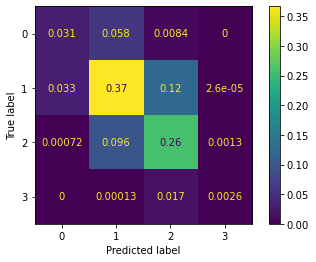

In [128]:
# Create confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(final_model, 
                      X_test_preprocessed_2, 
                      y_test,
                      normalize='all');
#plt.savefig('ConfusionMatrix_2.jpg')

## Model Conclusions

Even though this model has some difficulty identifying the outlier targets (0 and 3) it does a good job predicting whether a wine will be in the upper (2 and 3) or lower (0 and 1) half.  This model can be used reliably to predict if a wine will make it into the 'Very Good' tier, which would be very helpful for a wine maker.

# Wine Description Keywords

Since I have a model that can tell us how well the current wines would be perceived, I would next like to explore keywords for highly scoring wines.  This will help the wine maker know what flavor profiles to aim for in future wines.

In [129]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",VulkÃ Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin OâKeefe,@kerinokeefe,Nicosia 2013 VulkÃ Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwineÂ,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwineÂ,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


For this exploration, we will only need the 'description' and 'points' columns.

In [130]:
text_df = df.loc[:, ['description', 'points']]
text_df.head()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


In [131]:
# Check for missing values
text_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   description  129971 non-null  object
 1   points       129971 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.0+ MB


There are no missing values, so I will move on to language processing  

## Language Processing

In [132]:
# Lowercase text
text_df['description'] = text_df['description'].str.lower()
text_df.head()

,description,points
0,"aromas include tropical fruit, broom, brimston...",87
1,"this is ripe and fruity, a wine that is smooth...",87
2,"tart and snappy, the flavors of lime flesh and...",87
3,"pineapple rind, lemon pith and orange blossom ...",87
4,"much like the regular bottling from 2012, this...",87


In [133]:
# Remove punctuation and tokenize
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
text_df['text_tokenized'] = text_df['description'].apply(tokenizer.tokenize)
text_df.head()

,description,points,text_tokenized
0,"aromas include tropical fruit, broom, brimston...",87,"[aromas, include, tropical, fruit, broom, brim..."
1,"this is ripe and fruity, a wine that is smooth...",87,"[this, is, ripe, and, fruity, wine, that, is, ..."
2,"tart and snappy, the flavors of lime flesh and...",87,"[tart, and, snappy, the, flavors, of, lime, fl..."
3,"pineapple rind, lemon pith and orange blossom ...",87,"[pineapple, rind, lemon, pith, and, orange, bl..."
4,"much like the regular bottling from 2012, this...",87,"[much, like, the, regular, bottling, from, 201..."


In [134]:
# Using our function from above, remove stopwords
text_df['text_without_stopwords'] = text_df['text_tokenized'].apply(remove_stopwords)
text_df.head()

,description,points,text_tokenized,text_without_stopwords
0,"aromas include tropical fruit, broom, brimston...",87,"[aromas, include, tropical, fruit, broom, brim...","[aromas, include, tropical, broom, brimstone, ..."
1,"this is ripe and fruity, a wine that is smooth...",87,"[this, is, ripe, and, fruity, wine, that, is, ...","[ripe, fruity, smooth, still, structured, firm..."
2,"tart and snappy, the flavors of lime flesh and...",87,"[tart, and, snappy, the, flavors, of, lime, fl...","[tart, snappy, lime, flesh, rind, dominate, gr..."
3,"pineapple rind, lemon pith and orange blossom ...",87,"[pineapple, rind, lemon, pith, and, orange, bl...","[pineapple, rind, lemon, pith, orange, blossom..."
4,"much like the regular bottling from 2012, this...",87,"[much, like, the, regular, bottling, from, 201...","[much, like, regular, bottling, 2012, comes, a..."


In [135]:
# Using our function from above, lemmatize text
text_df['lemmatized_text'] = text_df['text_without_stopwords'].apply(lemmatize_text)
text_df.head()

,description,points,text_tokenized,text_without_stopwords,lemmatized_text
0,"aromas include tropical fruit, broom, brimston...",87,"[aromas, include, tropical, fruit, broom, brim...","[aromas, include, tropical, broom, brimstone, ...","[aroma, include, tropical, broom, brimstone, d..."
1,"this is ripe and fruity, a wine that is smooth...",87,"[this, is, ripe, and, fruity, wine, that, is, ...","[ripe, fruity, smooth, still, structured, firm...","[ripe, fruity, smooth, still, structured, firm..."
2,"tart and snappy, the flavors of lime flesh and...",87,"[tart, and, snappy, the, flavors, of, lime, fl...","[tart, snappy, lime, flesh, rind, dominate, gr...","[tart, snappy, lime, flesh, rind, dominate, gr..."
3,"pineapple rind, lemon pith and orange blossom ...",87,"[pineapple, rind, lemon, pith, and, orange, bl...","[pineapple, rind, lemon, pith, orange, blossom...","[pineapple, rind, lemon, pith, orange, blossom..."
4,"much like the regular bottling from 2012, this...",87,"[much, like, the, regular, bottling, from, 201...","[much, like, regular, bottling, 2012, comes, a...","[much, like, regular, bottling, 2012, come, ac..."


In [136]:
text_df.drop(['description', 
              'text_tokenized', 
              'text_without_stopwords'], axis=1, inplace=True)

Next, I will create dataframes for each points range that we used above:
* 80-84 points: 0 - Acceptable
* 85-89 points: 1 - Good
* 90-94 points: 2 - Very Good
* 95-100 points: 3 - Outstanding

## Acceptable Wines

In [137]:
acceptable_df = text_df[text_df['points']<=84]
acceptable_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12430 entries, 336 to 129629
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   points           12430 non-null  int64 
 1   lemmatized_text  12430 non-null  object
dtypes: int64(1), object(1)
memory usage: 291.3+ KB


In [138]:
acceptable_freq_dist = FreqDist(acceptable_df['lemmatized_text'].explode())

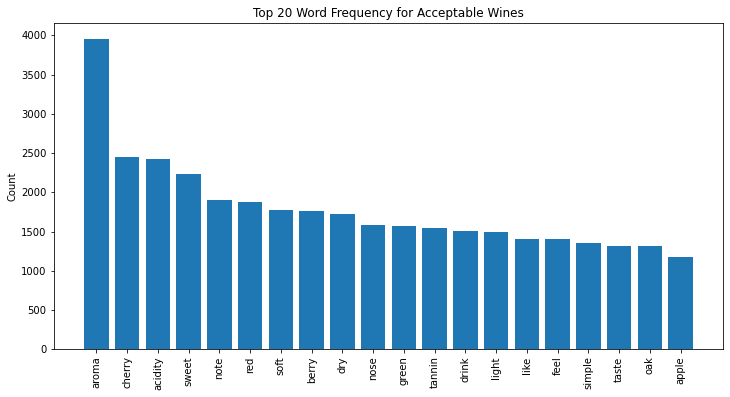

In [139]:
# Explore top 20 words
visualize_top_20(acceptable_freq_dist, 
                 "Top 20 Word Frequency for Acceptable Wines")

In [140]:
# Join text for Word Cloud
acceptable_df['final_text'] = acceptable_df['lemmatized_text'].apply(lambda x: ' '.join(x))
acceptable_df.head()

,points,lemmatized_text,final_text
336,83,"[gritty, heavily, roasted, aroma, peanut, herb...",gritty heavily roasted aroma peanut herbal ber...
337,83,"[easy, inviting, selection, mentholated, strea...",easy inviting selection mentholated streak sof...
338,82,"[earthy, somewhat, rustic, spoiled, spicy, pep...",earthy somewhat rustic spoiled spicy pepper ed...
339,82,"[red, color, berry, apple, aroma, sweet, heavy...",red color berry apple aroma sweet heavy body l...
340,82,"[nose, muted, despite, slight, spritz, equally...",nose muted despite slight spritz equally toned...


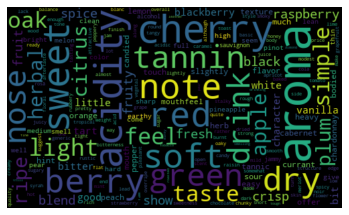

In [141]:
# Explore Word Cloud
acceptable_text = acceptable_df['final_text'].tolist()
acceptable_text = ' '.join(acceptable_text)

wordcloud_1 = WordCloud(width=500,
                      height=300,
                      collocations=False,
                      max_font_size=70).generate(acceptable_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
#plt.savefig('Acceptable_Cloud.jpg');

In this word cloud, we are seeing words like 'green', 'simple', 'acidity', 'bitter', and 'light'.  These words seem to be indicative of a wine that is lacking balance and body.

## Good Wines

In [142]:
good_df = text_df[text_df['points'].between(85,89)]
good_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68496 entries, 0 to 129852
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   points           68496 non-null  int64 
 1   lemmatized_text  68496 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [143]:
good_freq_dist = FreqDist(good_df['lemmatized_text'].explode())

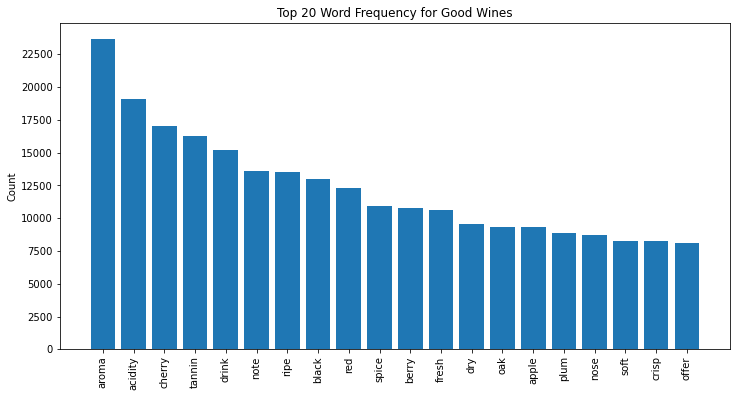

In [144]:
# Explore top 20 words
visualize_top_20(good_freq_dist, 
                 "Top 20 Word Frequency for Good Wines")

In [145]:
# Join text for Word Cloud
good_df['final_text'] = good_df['lemmatized_text'].apply(lambda x: ' '.join(x))

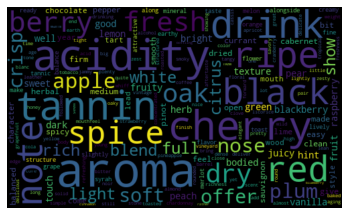

In [146]:
# Explore Word Cloud
good_text = good_df['final_text'].tolist()
good_text = ' '.join(good_text)

wordcloud_2 = WordCloud(width=500,
                      height=300,
                      collocations=False,
                      max_font_size=70).generate(good_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis("off")
#plt.savefig('Good_Cloud.jpg');

This word cloud shows us many fruit notes; 'apple', 'cherry', 'berry', 'citrus' as well as 'fresh' and 'crisp'.  These wines could be lacking depth of flavor or complexity.

## Very Good Wines

In [147]:
very_good_df = text_df[text_df['points'].between(90,94)]
very_good_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46629 entries, 119 to 129970
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   points           46629 non-null  int64 
 1   lemmatized_text  46629 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [148]:
very_good_freq_dist = FreqDist(very_good_df['lemmatized_text'].explode())

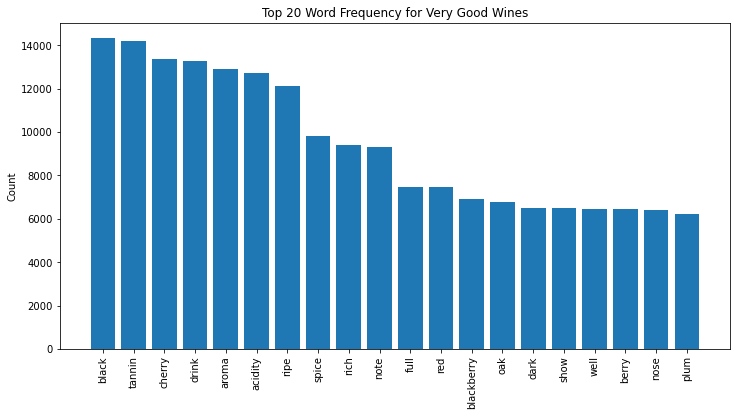

In [149]:
# Explore top 20 words
visualize_top_20(very_good_freq_dist, 
                 "Top 20 Word Frequency for Very Good Wines")

In [150]:
# Join text for Word Cloud
very_good_df['final_text'] = very_good_df['lemmatized_text'].apply(lambda x: ' '.join(x))

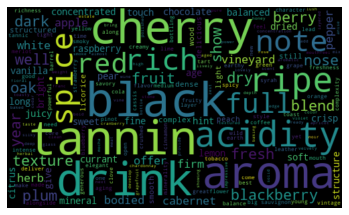

In [151]:
# Explore Word Cloud
very_good_text = very_good_df['final_text'].tolist()
very_good_text = ' '.join(very_good_text)

wordcloud_3 = WordCloud(width=500,
                      height=300,
                      collocations=False,
                      max_font_size=70).generate(very_good_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.axis("off")
#plt.savefig('Very_Good_Cloud.jpg');

In this word cloud we are starting to see bolder words; 'black', 'ripe', 'rich', 'plum', 'texture', and 'chocolate'.  These wines seem to be more complex and less fruit forward.

## Outstanding Wines

In [152]:
outstanding_df = text_df[text_df['points']>=95]
outstanding_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2416 entries, 345 to 128684
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   points           2416 non-null   int64 
 1   lemmatized_text  2416 non-null   object
dtypes: int64(1), object(1)
memory usage: 56.6+ KB


In [153]:
outstanding_freq_dist = FreqDist(outstanding_df['lemmatized_text'].explode())

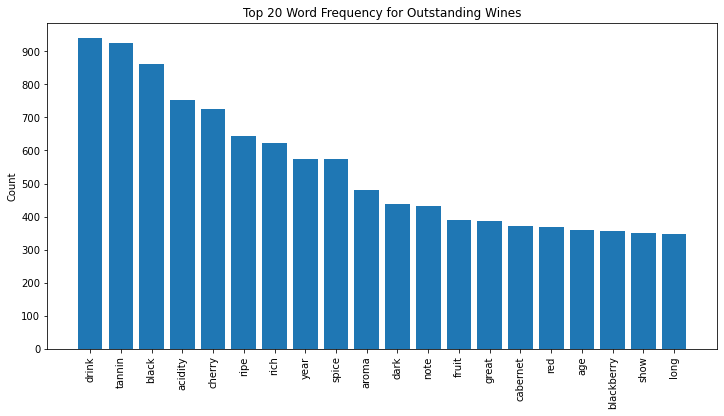

In [154]:
# Explore top 20 words
visualize_top_20(outstanding_freq_dist, 
                 "Top 20 Word Frequency for Outstanding Wines")

In [155]:
# Join text for Word Cloud
outstanding_df['final_text'] = outstanding_df['lemmatized_text'].apply(lambda x: ' '.join(x))

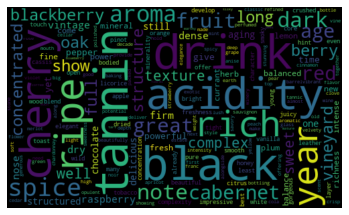

In [156]:
# Explore Word Cloud
outstanding_text = outstanding_df['final_text'].tolist()
outstanding_text = ' '.join(outstanding_text)

wordcloud_4 = WordCloud(width=500,
                      height=300,
                      collocations=False,
                      max_font_size=70).generate(outstanding_text)

import matplotlib.pyplot as plt
plt.imshow(wordcloud_4, interpolation='bilinear')
plt.axis("off")
#plt.savefig('Outstanding_Cloud.jpg');

One interesting word that immediately jumps to the eye is 'cabernet'. This variety would be worth exploring since it is the only variety that made it into any of our word clouds. These outstanding wines are also characterized by the words 'complex', 'spice', 'dense', 'time', 'aging' and 'pepper'.  These words seem to point us in the direction of full bodied and complex red wines that have been aged for a decent period of time.

## Keyword Conclusions

Based on our findings from the wine descriptions, higher scoring wines seem to be ones that have greater complexity and body and spend more time aging. It also seems as though Cabernets could be a good direction to move in.  Outstanding wines also move past the straightforward fruit flavors and into more unusual wine flavors such as spice, pepper, and chocolate.

# Wine Varieties

Finally, I would like to look into which wine varieties are currently receiving high scores.

In [157]:
# Reexamine our dataframe
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",VulkÃ Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin OâKeefe,@kerinokeefe,Nicosia 2013 VulkÃ Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwineÂ,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwineÂ,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


## Mean Scores

In [158]:
# Create a new dataframe with only points and variety
variety_df = df.loc[:, ['points', 'variety']]
variety_df.head()

,points,variety
0,87,White Blend
1,87,Portuguese Red
2,87,Pinot Gris
3,87,Riesling
4,87,Pinot Noir


In [159]:
# Check how many different varieties there are
variety_df['variety'].value_counts()

Pinot Noir                    13272
Chardonnay                    11753
Cabernet Sauvignon             9472
Red Blend                      8946
Bordeaux-style Red Blend       6915
                              ...  
Athiri                            1
Mavroudi                          1
Ojaleshi                          1
Cabernet Sauvignon-Barbera        1
PaÃ­s                             1
Name: variety, Length: 707, dtype: int64

Since there are so many different wine varieties in this dataset (707), we will limit our scope to the 15 that had the most reviews.  It is important to note that these are not necessarily the 15 highest rated wines, they are just the 15 that we have the most information on.  

I chose to go this route because I believe that the more ratings a wine has, the more common the wine.  I believe there will be many wines in this dataset that are very obscure and we would like to focus on wines that a new winery could potentially produce.

In [160]:
# Check the top 15 most commonly rated wines
variety_df['variety'].value_counts().head(15)

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Riesling                     5189
Sauvignon Blanc              4967
Syrah                        4142
RosÃ©                        3564
Merlot                       3102
Nebbiolo                     2804
Zinfandel                    2714
Sangiovese                   2707
Malbec                       2652
Portuguese Red               2466
Name: variety, dtype: int64

In [161]:
# Create a dataframe that only includes top 15 varieties
top_15_varieties = ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon',
                   'Red Blend', 'Bordeaux-style Red Blend', 'Riesling',
                   'Sauvignon Blanc', 'Syrah', 'RosÃ©', 'Merlot',
                   'Nebbiolo', 'Zinfandel', 'Sangiovese', 'Malbec',
                   'Portuguese Red']
top_15_df = variety_df[variety_df['variety'].isin(top_15_varieties)]
top_15_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84665 entries, 1 to 129967
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   points   84665 non-null  int64 
 1   variety  84665 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [162]:
# Group varieties by their mean point scores
grouped_df = top_15_df.groupby('variety').mean()
grouped_df.sort_values(by='points', ascending=False, inplace=True)
grouped_df.reset_index(inplace=True)
grouped_df

,variety,points
0,Nebbiolo,90.251070
1,Riesling,89.450183
2,Pinot Noir,89.411468
3,Syrah,89.286577
4,Bordeaux-style Red Blend,89.106435
5,Portuguese Red,88.810624
6,Cabernet Sauvignon,88.607580
7,Sangiovese,88.550794
8,Red Blend,88.380282
9,Chardonnay,88.340083


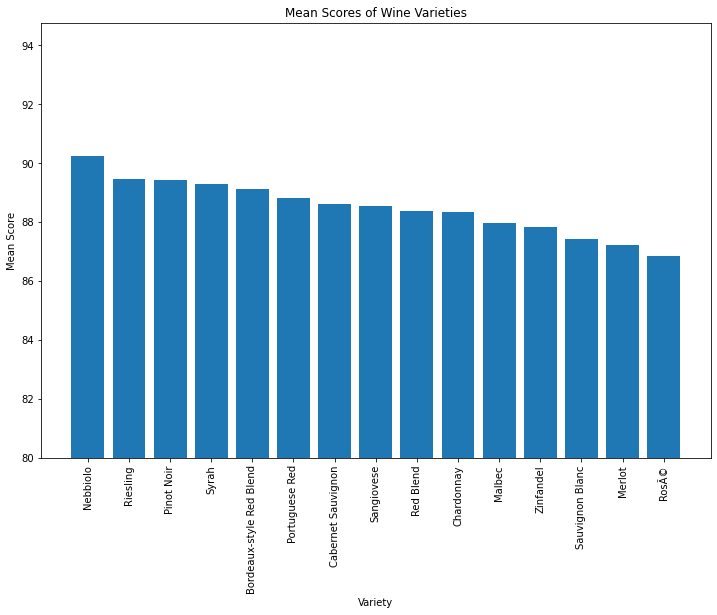

In [163]:
# Plot the scores
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(grouped_df['variety'], grouped_df['points'])
plt.xticks(rotation=90)
plt.ylim(bottom=80)
plt.xlabel('Variety')
plt.ylabel('Mean Score')
plt.title('Mean Scores of Wine Varieties')
plt.savefig('Mean_Variety_Scores.jpg');

The wines with the top 5 highest mean scores are:
* Nebbiolo
* Riesling
* Pinot Noir
* Syrah
* Bordeaux-style Red Blend

## Outstanding Scores

Next, lets look at the varieties that are common in the 'Outstanding' point range (95-100).

In [164]:
top_15_df['number'] = 1
top_15_df.head()

,points,variety,number
1,87,Portuguese Red,1
3,87,Riesling,1
4,87,Pinot Noir,1
10,87,Cabernet Sauvignon,1
12,87,Cabernet Sauvignon,1


In [165]:
top_15_df.groupby('points').sum().sort_values(by='points', ascending=False)

,number
points,
100,12
99,27
98,58
97,178
96,409
95,1201
94,2922
93,4846
92,6825


In [166]:
outstanding_points_df = top_15_df[top_15_df['points'].between(95,100)]
outstanding_points_df

,points,variety,number
347,97,Riesling,1
350,97,Nebbiolo,1
352,96,Chardonnay,1
353,96,Chardonnay,1
354,96,Riesling,1
...,...,...,...
128270,97,Cabernet Sauvignon,1
128681,95,Chardonnay,1
128682,95,Pinot Noir,1
128683,95,Pinot Noir,1


In [167]:
outstanding_points_df.groupby('variety').sum().sort_values(by='number', ascending=False)

,points,number
variety,,
Pinot Noir,38373,402
Cabernet Sauvignon,26204,274
Bordeaux-style Red Blend,24547,256
Chardonnay,24152,253
Riesling,18506,194
Nebbiolo,14443,151
Red Blend,8417,88
Syrah,8145,85
Sangiovese,6315,66


The wines most commonly rated 'Outstanding':
* Pinot Noir
* Cabernet Sauvignon
* Bordeaux-style Red Blend
* Chardonnay
* Riesling

## Perfect Scores

Finally, lets explore the varieties with a perfect score of 100 points.

In [168]:
perfect_points_df = top_15_df[top_15_df['points']==100]
perfect_points_df

,points,variety,number
39286,100,Merlot,1
42197,100,Portuguese Red,1
45781,100,Sangiovese,1
45798,100,Cabernet Sauvignon,1
58352,100,Bordeaux-style Red Blend,1
89729,100,Chardonnay,1
111753,100,Bordeaux-style Red Blend,1
111755,100,Bordeaux-style Red Blend,1
111756,100,Bordeaux-style Red Blend,1
113929,100,Syrah,1


In [169]:
perfect_points_df.groupby('variety').sum().sort_values(by='number', ascending=False)

,points,number
variety,,
Bordeaux-style Red Blend,500,5
Syrah,200,2
Cabernet Sauvignon,100,1
Chardonnay,100,1
Merlot,100,1
Portuguese Red,100,1
Sangiovese,100,1


The two wines that have received a perfect score more than once are:
* Bordeaux-style Red Blend (5 times)
* Syrah (2 times)

## Wine Varieties Conclusions

Based on these findings, the three wines that I believe have the best potential to receive high scores are:
* **Bordeaux-style Red Blend** - high mean score, commonly in the outstanding point range, five perfect scores
* **Pinot Noir** - high mean score, commonly in the outstanding point range
* **Syrah** - high mean score, two perfect scores

# Recommendations

**Naive Bayes Model** - This model can be used reliably to predict if a wine will make it into the 'Very Good' tier, which will helpful for a wine maker to assess their current wines. I would recommend using this model to understand who well current wines would be received.

**Keywords** - Based on our findings for wine description keywords, I would recommend producing complex, aged red wines with deep flavor profiles.  I would also suggest exploring flavors such as spice, pepper, and chocolate in full bodied wines.

**Varieties** - The three varieties that I would recommend producing are:
* Bordeaux-style Red Blend - Full bodied red wine with hints of chocolate and black current.
* Pinot Noir - Versatile red wine loved for its red fruit and spice flavors and smooth finish.
* Syrah - Rich, meaty red wine characterized by tobacco, plum, and peppercorn. 

These wines historically score highly and also correspond with the keywords we discovered above.

# Next Steps

**Putting Model into Action** - The first step I would take is gathering the data from our current wines to predict their score level.

**Exploring Wineries** - One next step we could take is exploring the different wineries in the dataset.  If certain wineries are receiving high scores for their wines, we can look into their processes for creating wines.

**Recommendation System** - Finally, I would recommend building a recommendation system for the tasters at Wine Enthusiast to help understand which wines to market toward each.